In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual

import os

## Read the dataset

In [2]:
from dataloaders.germany_dataset import load_image_and_labels
from image_helpers import polygons_to_bounding_boxes, polygons_to_masks, mask_to_polygons
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes
from torchvision.tv_tensors import BoundingBoxes, Mask

In [3]:
def plot_image_and_mask(image, masks):
    # Convert images to uint8
    image = (image * 255).byte()
    
    # Convert masks to bool
    masks = masks.bool()
    
    # Draw the masks on the image
    image_with_masks = draw_segmentation_masks(image, masks)
    
    # Convert to PIL image
    image_with_masks = image_with_masks.permute(1, 2, 0).numpy()
    
    # Plot the image
    plt.imshow(image_with_masks)
    plt.show()
    

In [4]:
from dataloaders.solar_dk_dataset import SolarDKDataset
import torchvision.transforms.v2 as transforms

train_folder = "data/solardk_dataset_neurips_v2/gentofte_trainval/train"
validation_folder = "data/solardk_dataset_neurips_v2/gentofte_trainval/val"

train_dataset = SolarDKDataset(train_folder)
validation_dataset = SolarDKDataset(validation_folder)

tensor([0., 1.])


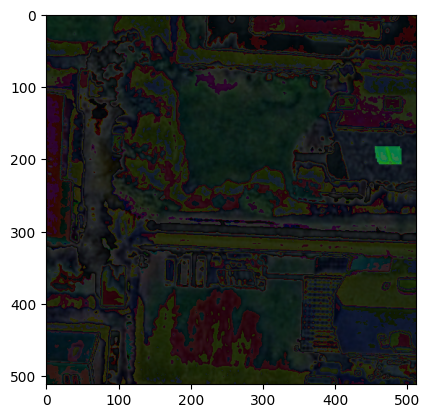

In [5]:
image, mask = train_dataset[0]
plot_image_and_mask(image, mask)

### Load the dataset

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
validation_dataset = DataLoader(validation_dataset, batch_size=4, shuffle=False, num_workers=4)

### Train the model

In [7]:
import pytorch_lightning as pl
from models.base import BaseModel
from models.architectures.deep_lab import DeepLabModel
# from models.architectures.mask_rcnn import MaskRCNNModel
from models.architectures.unet import UNetModel

In [8]:
for image, label in train_dataloader:
    # Print the size of the image and label
    print(image.size(), label.size())  
    break

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
torch.Size([4, 3, 512, 512]) torch.Size([4, 2, 512, 512])


In [9]:
from torchmetrics.functional.classification import dice

class CombinedBCEDiceLoss(torch.nn.Module):
    def __init__(self):
        super(CombinedBCEDiceLoss, self).__init__()
        self.bce = torch.nn.BCEWithLogitsLoss()

    def forward(self, y_hat, y):
        bce = self.bce(y_hat, y)
        y_hat = torch.sigmoid(y_hat)
        dice_loss = 1 - dice(y_hat, y.int())
        return bce + dice_loss

/home/tue/20231335/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/home/tue/20231335/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.


tensor([0.])
tensor([0.])tensor([0., 1.])

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0., 1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor(1)
Dice Score: 0.39763420820236206
Jaccard Index: 0.6215476989746094
Accuracy: 0.9949493408203125
Precision: 0.9949493408203125
Recall: 0.9949493408203125
F1 Score: 0.9949493408203125


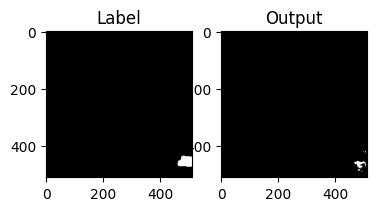

In [10]:
import torch
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
from PIL import Image

from torchmetrics.functional import jaccard_index, accuracy, precision, recall, f1_score, dice

test_folder = "data/solardk_dataset_neurips_v2/herlev_test/test"

model = BaseModel.load_from_checkpoint("lightning_logs/version_206455/checkpoints/last.ckpt")

test_dataset = SolarDKDataset(test_folder)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

task = "multiclass"
num_classes = 2

# Loop on train dataloader until mask is not just zeros
for image, label in train_dataloader:
    # Check if the second channel of any of the batches is not all zeros
    if (label[:, 1] != 0).any():
        id = (label[:, 1] != 0).nonzero(as_tuple=True)[0][0]
        print(id)
        break
        
        
# Estimate the model on the test set
model.eval()
with torch.no_grad():
    output = model(image)
    
    output = output[id]
    label = label[id]
    
    # sigmoid_predictions = torch.sigmoid(output)
    # output_predictions = (torch.sigmoid(output) > 0.1).float().squeeze()
    output_predictions = output.argmax(dim=0).float().squeeze()
    label = label.argmax(dim=0).float().squeeze()
    
    print(f"Dice Score: {dice(output_predictions, label.int())}")
    print(f"Jaccard Index: {jaccard_index(output_predictions, label, task=task, num_classes=num_classes)}")
    print(f"Accuracy: {accuracy(output_predictions, label, task=task, num_classes=num_classes)}")
    print(f"Precision: {precision(output_predictions, label, task=task, num_classes=  num_classes)}")
    print(f"Recall: {recall(output_predictions, label, task=task, num_classes=num_classes)}")
    print(f"F1 Score: {f1_score(output_predictions, label, task=task, num_classes=num_classes)}")
    
    plt.subplot(1, 3, 2)
    plt.imshow(label, cmap="gray")
    plt.title("Label")
    
    plt.subplot(1, 3, 3)
    r = Image.fromarray(output_predictions.byte().cpu().numpy())
    plt.imshow(r, cmap="gray")
    plt.title("Output")
    
    plt.show()
    
        